Map the position of the flux

# Imports

In [1]:
import cmocean.cm as cm
import glob
from matplotlib.colors import LogNorm, Normalize
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import scipy.interpolate as interp

from salishsea_tools import nc_tools

%matplotlib inline

/home/sallen/anaconda/envs/py36/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Get Grid Info Data

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdepw_1d)
figrid = 386
igrid = figrid-1
fmask = mymesh.fmask[0, :, igrid]
tmask = mymesh.tmask[0]
nav_lon = mymesh.nav_lon[igrid]
u_lons = mymesh.glamv[0, igrid]    # note switch to v with the switch from t to f
f_lons = mymesh.glamf[0, igrid]
w_depths = mymesh.gdepw_1d

# Twelve Hours : 01sep15

In [3]:
file = '/data/sallen/results/Ariane/BackNorth/01sep15/ariane_positions_quantitative.nc'
tidefile = '/results/SalishSea/nowcast-green/01sep15/PointAtkinson.nc'

In [4]:
def get_data(mydata, section, time):
    lons = mydata.init_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.init_z[(mydata.final_section==section) & (mydata.init_t==time)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section) & (mydata.init_t==time)]
    return lons, depths, transports

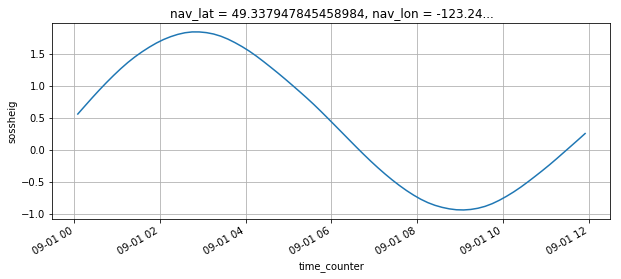

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
with xr.open_dataset(tidefile) as tidedata:
    tidedata.sossheig[0:72].plot(ax=ax)
ax.grid(which='both')

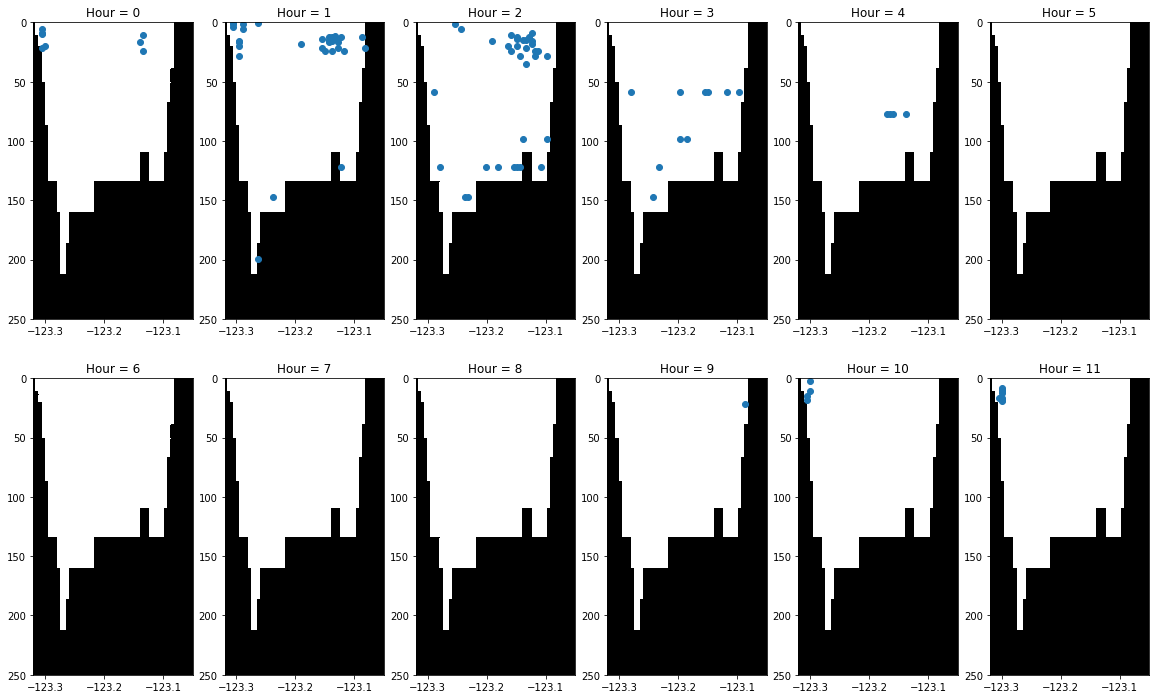

In [6]:
mydata = xr.open_dataset(file)
section = 2
time1 = mydata.init_t[0]
fig, axs = plt.subplots(2, 6, figsize=(20, 12))
x, y = np.meshgrid(u_lons, w_depths)
for hour in range(12):
    ax = axs[int(hour/6), hour-6*int(hour/6)]
    lons, depths, transports = get_data(mydata, section, time1+hour)
    ax.pcolormesh(x, y, fmask, cmap='Greys_r')
    ax.plot(lons, depths, 'o')
    ax.invert_yaxis()
    ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((250, 0))
    ax.set_title("Hour = "+str(hour))

# Fifteen Days 01sep15-15sep15

In [7]:
sevendays = (sorted(glob.glob('/data/sallen/results/Ariane/BackNorth/0*sep15/ariane_positions_quantitative.nc')) +
            sorted(glob.glob('/data/sallen/results/Ariane/BackNorth/1[012345]sep15/ariane_positions_quantitative.nc')))
tidefile = (sorted(glob.glob('/results/SalishSea/nowcast-green/0*sep15/PointAtkinson.nc')) +
            sorted(glob.glob('/results/SalishSea/nowcast-green/1[012345]sep15/PointAtkinson.nc')))
salfile = (sorted(glob.glob('/results/SalishSea/nowcast-green/0*sep15/SalishSea_1d_2015090*_2015090*_grid_T.nc')) +
           sorted(glob.glob('/results/SalishSea/nowcast-green/1[012345]sep15/SalishSea_1d_2015091[012345]_2015091[012345]_grid_T.nc')))

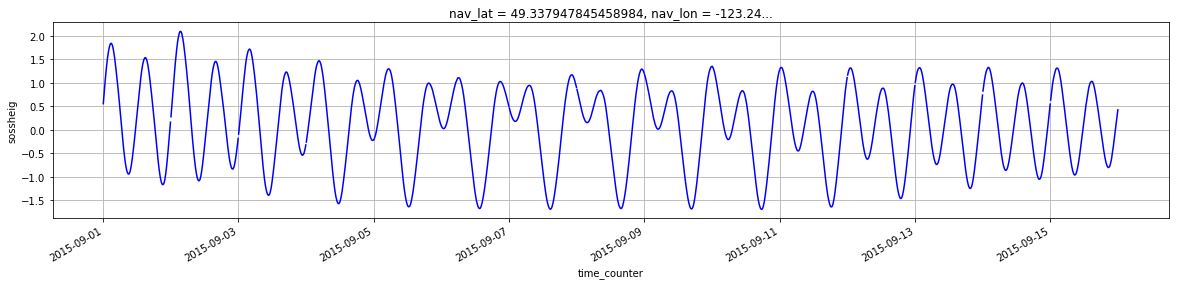

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
for file in tidefile:
    with xr.open_dataset(file) as tidedata:
        tidedata.sossheig.plot(ax=ax, color='b')
ax.grid(which='both')

In [9]:
def draw_patches(fmask, ll, ul, u_lons, w_depths):
    topo = []
    for i in range(ll,ul):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((u_lons[i], w_depths[j]), u_lons[i+1]-u_lons[i], w_depths[j+1]-w_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='burlywood', edgecolors='burlywood')
    return(pc)

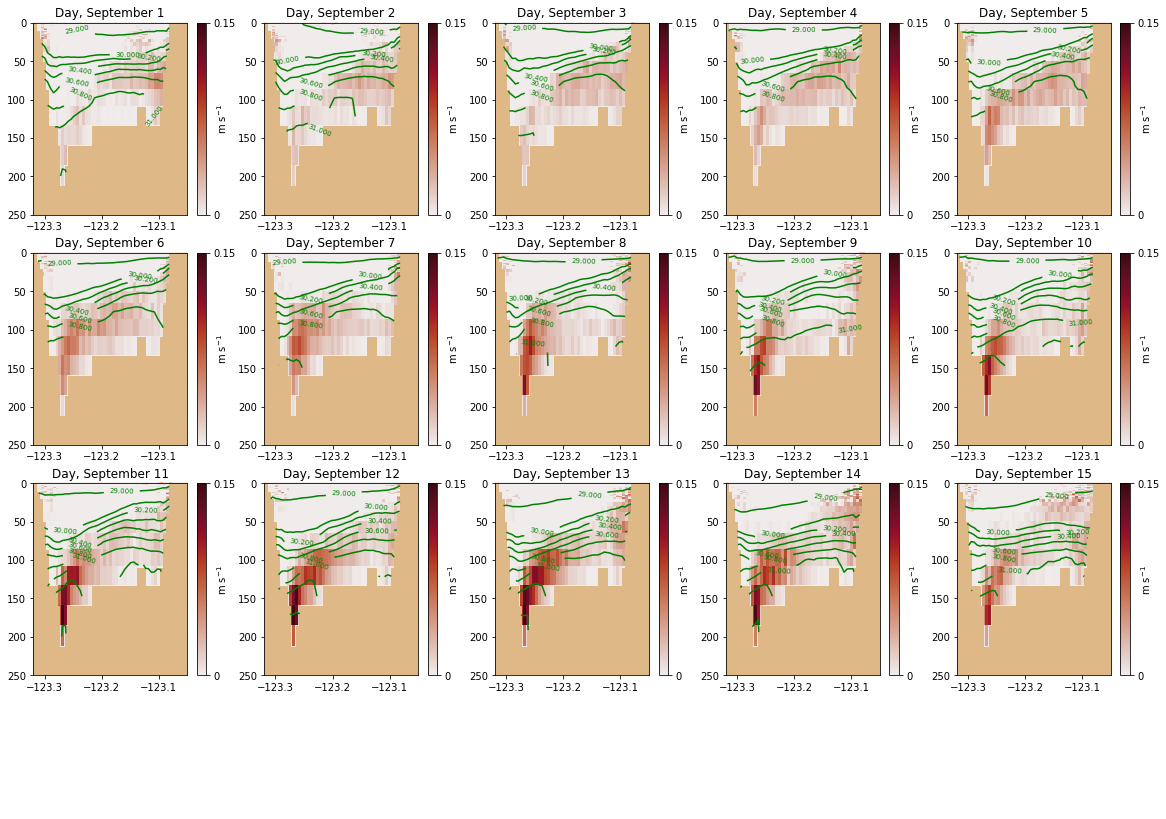

In [10]:
section = 2
m2lon = ((u_lons[314]-u_lons[260])/(mymesh.e2f[0, igrid, 260:314].sum()))
tmax = 1378670
vvmax = 0.15/float(m2lon)*24/tmax
xs, ys = np.meshgrid(np.array(mymesh.glamv[0, igrid]), np.array(mymesh.gdept_1d))
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for day, f in enumerate(sevendays):
    ax = axs[int(day/5), day-5*int(day/5)]
    mydata = xr.open_dataset(f)
    lons = mydata.init_lon[(mydata.final_section==section)]
    depths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.init_transp[(mydata.final_section==section)]
    vmax = vvmax*tmax/float(transports.sum())
    c, xedge, yedge, im = ax.hist2d(lons, 
                                depths,
                                weights=transports,
                                bins=[np.array(f_lons[260:314]), w_depths[0]], cmap=cm.amp, 
                                    normed=True, vmax=vmax)
    pc = draw_patches(fmask, 260, 314, np.array(u_lons), np.array(w_depths[0]))
    ax.add_collection(pc)
    cb1 = fig.colorbar(im, ax=ax) 
    cb1.set_ticks([0, vmax])
    cb1.set_ticklabels([0, f'{vmax * float(m2lon) * float(transports.sum())/24.:.2f}'])
    cb1.set_label('m s$^{-1}$', labelpad=-20)
    salinity = 0.5*(np.ma.array(xr.open_dataset(salfile[day]).vosaline[0, :, igrid],
                       mask=1-tmask[:, igrid]) +
                    np.ma.array(xr.open_dataset(salfile[day]).vosaline[0, :, igrid+1],
                       mask=1-tmask[:, igrid+1]))
    CS = ax.contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
    ax.clabel(CS, inline=1, fontsize=7)
    ax.invert_yaxis()
    ax.set_xlim((-123.32, -123.05))
    ax.set_ylim((250, 0))
    ax.set_title("Day, September "+str(day+1))
    mydata.close()

# Month of September

In [11]:
amonth = glob.glob('/data/sallen/results/Ariane/BackNorth/*sep15/ariane_positions_quantitative.nc')
salinity = 0.5*(np.ma.array(xr.open_dataset('/data/sallen/results/Ariane/Salinity/SalishSea_1month_201509_grid_T.nc').vosaline[0, :, igrid],
                       mask=1-tmask[:, igrid]) +
                    np.ma.array(xr.open_dataset('/data/sallen/results/Ariane/Salinity/SalishSea_1month_201509_grid_T.nc').vosaline[0, :, igrid+1],
                       mask=1-tmask[:, igrid+1]))

In [12]:
section = 2
mydata = xr.open_dataset(amonth[0])
lons = mydata.init_lon[(mydata.final_section==section)]
depths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
transports = mydata.init_transp[(mydata.final_section==section)]
for f in amonth[1:]:
    mydata = xr.open_dataset(f)
    lons = np.concatenate((lons, mydata.init_lon[(mydata.final_section==section)]))
    depths = np.concatenate((depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    transports = np.concatenate((transports, mydata.init_transp[(mydata.final_section==section)]))

In [13]:
amonth = glob.glob('/data/sallen/results/Ariane/InGIslands/*sep15/ariane_positions_quantitative.nc')
section = 2
for f in amonth:
    mydata = xr.open_dataset(f)
    lons = np.concatenate((lons, mydata.init_lon[(mydata.final_section==section)]))
    depths = np.concatenate((depths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    transports = np.concatenate((transports, mydata.init_transp[(mydata.final_section==section)]))

In [14]:
amonth = glob.glob('/data/sallen/results/Ariane/FullNorth/*sep15/ariane_positions_quantitative.nc')
section = 2
mydata = xr.open_dataset(amonth[0])
olons = mydata.init_lon[(mydata.final_section==section)]
odepths = depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]
otransports = mydata.init_transp[(mydata.final_section==section)]
for f in amonth[1:]:
    mydata = xr.open_dataset(f)
    olons = np.concatenate((olons, mydata.init_lon[(mydata.final_section==section)]))
    odepths = np.concatenate((odepths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    otransports = np.concatenate((otransports, mydata.init_transp[(mydata.final_section==section)]))

In [15]:
amonth = glob.glob('/data/sallen/results/Ariane/SouthGIslands/*apr15/ariane_positions_quantitative.nc')
section = 2
for f in amonth:
    mydata = xr.open_dataset(f)
    olons = np.concatenate((olons, mydata.init_lon[(mydata.final_section==section)]))
    odepths = np.concatenate((odepths, depthf(mydata.init_z[(mydata.final_section==section)]-1.)[0]))
    otransports = np.concatenate((otransports, mydata.init_transp[(mydata.final_section==section)]))

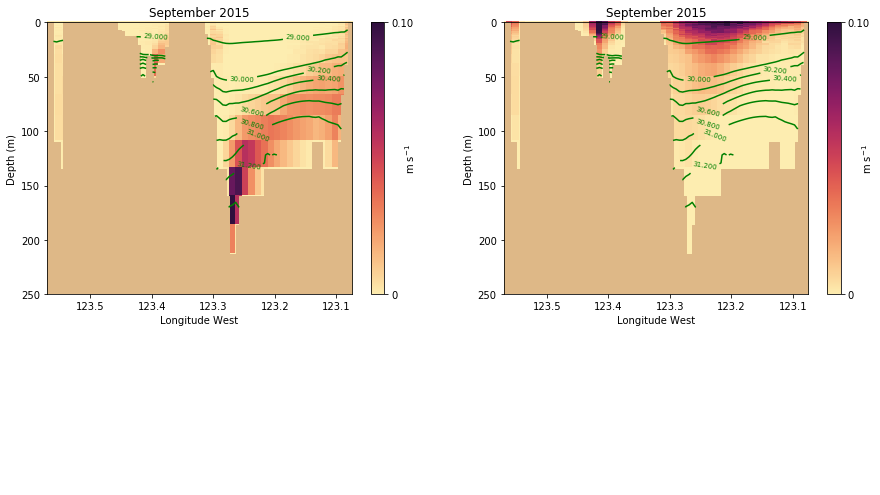

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
vmax = 0.22 / transports.sum() * 31097863.7006
v2max = 0.22 / otransports.sum() * 31097863.7006
jmin = 210
gridding = 2
c, xedge, yedge, im = axs[0].hist2d(lons, 
                                depths,
                                weights=transports,
                                bins=[np.array(f_lons[jmin:314:gridding]), w_depths[0]], cmap=cm.matter, 
                                    normed=True, vmax=vmax)
yes = yedge.copy()
CS = axs[0].contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
axs[0].clabel(CS, inline=1, fontsize=7)
pc = draw_patches(fmask, jmin, 314, np.array(u_lons), np.array(w_depths[0]))
axs[0].add_collection(pc)
cb1 = fig.colorbar(im, ax=axs[0]) 
cb1.set_ticks([0, vmax])

cb1.set_label('m s$^{-1}$', labelpad=-10)
c, xedge, yedge, im = axs[1].hist2d(olons, 
                                odepths,
                                weights=otransports,
                                bins=[np.array(f_lons[jmin:314:gridding]), w_depths[0]], cmap=cm.matter, 
                                    normed=True, vmax=v2max)
CS = axs[1].contour(xs, ys, salinity,  [29, 30, 30.2, 30.4, 30.6, 30.8, 31, 31.2, 31.4], colors='g')
axs[1].clabel(CS, inline=1, fontsize=7)
pc = draw_patches(fmask, jmin, 314, np.array(u_lons), np.array(w_depths[0]))
axs[1].add_collection(pc)
cb2 = fig.colorbar(im, ax=axs[1]) 
cb2.set_ticks([0, v2max])
cb2.set_label('m s$^{-1}$', labelpad=-10)
for ax in axs:
    ax.invert_yaxis()
    ax.set_xlim((-123.57, -123.075))
    ax.set_ylim((250, 0))
    ax.set_xticks(np.arange(-123.5, -123.1, 0.1))
    ax.set_xticklabels(np.arange(123.5, 123.1, -0.1))
    ax.set_xlabel('Longitude West')
    ax.set_ylabel('Depth (m)')
    ax.set_title("September 2015")
cb1.set_ticklabels([0, f'{vmax * float(m2lon) * transports.sum()/24/30:.2f}'])
cb2.set_ticklabels([0, f'{v2max * float(m2lon) * float(otransports.sum())/24./30.:.2f}'])

Problems: cell size needs to be taken into account.  What are the units exactly?

In [ ]:
print(mydata.init_lat, mydata.init_x, mydata.init_y)

In [ ]:
0.5*(mymesh.nav_lat[386-1, 268-1]+mymesh.nav_lat[386-1, 269-1])

In [ ]:
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 265], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 266], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 267], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 268], '-o')
plt.plot(range(380, 390), 0.5*(mymesh.nav_lat[380:390, 268]+mymesh.nav_lat[380:390, 269]), '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 269], '-o')
plt.plot(range(380, 390), 48.893097*np.ones(10))
plt.plot(385.5, 0.5*(mymesh.nav_lat[385, 268]+mymesh.nav_lat[386, 268]), '-co')

In [ ]:
Choices: 385 and 269
    385.5 and 268
    386 and 267
and its saying 268.5 and 386    

In [ ]:
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 302], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 303], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 304], '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 305], '-o')
plt.plot(range(380, 390), 0.5*(mymesh.nav_lat[380:390, 305]+mymesh.nav_lat[380:390, 306]), '-o')
plt.plot(range(380, 390), mymesh.nav_lat[380:390, 306], '-o')
plt.plot(range(380, 390), 48.963257*np.ones(10))
plt.plot(385.5, 0.5*(mymesh.nav_lat[385, 305]+mymesh.nav_lat[386, 305]), '-co')